In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from ast import literal_eval


In [2]:
pd.options.display.max_columns = None

In [3]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
!pip install category_encoders
import category_encoders as ce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Импорт данных 

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#подгружаем файлы с тренировочными и тестовыми данными в разные датафреймы
hotels_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotels_train.csv')
hotels_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotels_test.csv')
sample_submission=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotels_submission.csv')

Изучаем структуру датафреймов

In [9]:
hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [10]:
hotels_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [11]:
hotels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [12]:
hotels_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


В тестовых данных отсутствует целевая переменная reviewer_score. Создадим этот признак и заполним значением 0.

In [13]:
hotels_test['reviewer_score']=0

### Очистка тренировочного датасета

#### Удаление дубликатов

In [14]:
columns=list(hotels_train.columns)

In [15]:
hotels_train=hotels_train.drop_duplicates(subset=columns)
hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 

Удалено 307 дубликатов из тренировочного датасета.
В тестовых данных удалять строки не будем, так как предстоит отправить результаты по тестовой выборке в соревнование - для корректного подсчета контрольной метрики количество строк должно быть сохранено.

Объединяем датафреймы для последующей обработки.
Но прежде добавим в них столбцы  них столбцы sample с пометкой о тренировочных и тестовых данных, чтобы в дальнейшнем можно было разделить данные по этому признаку.

In [16]:
hotels_train['sample']='train'
hotels_test['sample']='test'

#объединение наборов данных в один датафрейм
hotels = hotels_test.append(hotels_train, sort=False).reset_index(drop=True)

Проверяем получившийся датафрейм

In [17]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Количество строк равно сумме строк двух наборов данных, столбцов - 18.

### Распределение числовых признаков

Оценим распределение числовых признаков методом describe.

In [18]:
hotels_train.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,384048.000000,384048.000000
mean,498.504375,8.397421,18.539400,2744.679231,17.778163,7.176211,8.397299,49.443988,2.823740
std,500.365093,0.547861,29.703569,2316.934876,21.724766,11.052453,1.635747,3.468266,4.580782
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214277,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.500198,-0.000250
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,9.600000,51.516384,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


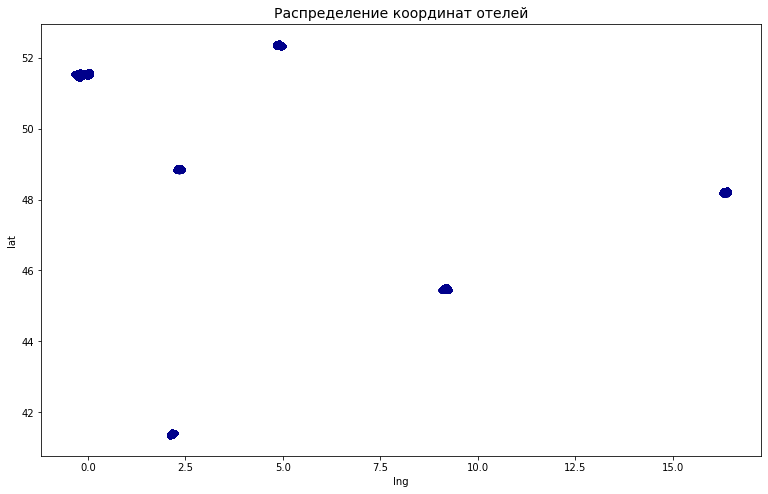

In [19]:
#распределение координат отелей оценим визуально
axes=plt.figure(figsize=(10,6)).add_axes([0,0,1,1])
hotels_train.plot.scatter(x='lng',
                      y='lat',
                      c='DarkBlue',
                      ax=axes);
axes.set_title('Распределение координат отелей',fontsize=14);

Координат локализованы в 6 областях - предположительно  в 6 городах. Явных выбросов в данных широты и долготы визуально не наблюдается.

Признаки review_total_negative_word_counts и review_total_negative_word_counts принимают минимальное значение 0. Необходимо проверить, как выглядят тексты этих отрицательных и положительных отзывов, в которых количество слов равно 0, и обработать эти данные.

In [20]:
hotels_train[hotels_train['review_total_positive_word_counts']==0]['positive_review'].value_counts()

No Positive    26863
Name: positive_review, dtype: int64

In [21]:
hotels_train[hotels_train['review_total_negative_word_counts']==0]['negative_review'].value_counts()

No Negative    95833
Name: negative_review, dtype: int64

Видно, что если рецензент оставил поле для положительного отзыва пустым, то в таблице это поле заполнено как "No positive", если оставил поле для отрицательного отзыва пустым - заполняется как "No negative". Вернемся к этому выводу позже, на этапе обработки текста отзывов.


### Проектирование признаков - этап 1

#### Извлечение количества ночей из тегов

В тегах часто встречается информация о количестве ночей, например "Stayed 1 night", "Stayed 2 nights". Извлечем эту информацию в отдельный признак, а на 
этапе проверки пропущенных значений посмотрим, насколько будет заполнен этот признак.

In [22]:
def extract_nights(cell):
    list_words=cell.split()
    if 'Stayed' in list_words:
        num_nights=list_words[list_words.index('Stayed')+1] #из списка слов в строке извлекаем слово, следующее за "Stayed"
        return num_nights
hotels['nights_stayed']=hotels['tags'].apply(extract_nights)

In [23]:
hotels['nights_stayed'].describe()

count     515239
unique        31
top            1
freq      193568
Name: nights_stayed, dtype: object

Посетители останавливаются в отелях на срок от 1 до 31 ночи

#### Извлечение количества мест в номере из тегов

Иногда в тегах втречается информация о количестве комнат или мест в номере.
Выведем теги из первых 30 отзывов и посмотрим, в каких вариациях встречаются такие теги

In [24]:
#смотрим, какие варианты тегов встречаются в таблице
for i in range(30):
  print(hotels['tags'].iloc[i])

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']
[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']
[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Couple ', ' Ambassador Junior Suite ', ' Stayed 1 night ']
[' Business trip ', ' Solo traveler ', ' Classic Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' Business trip ', ' Solo traveler ', ' Standard Double or Twin Room ', ' Stayed 1 night ']
[' Leisure trip ', ' Couple ', ' Queen Room ', ' Stayed 1 night ']
[' Business trip ', ' Solo traveler ', ' Executive Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
[' Group ', ' Double or Twin Room ', ' Stayed 1 night ']
[' Couple ', ' Standard Triple Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ']
[' Leisure trip ', ' Group ', ' Large R

Извлекаем информацию о количестве мест/комнат. По умолчанию принимаем, что если в отзыве нет тега с количеством мест в номере, то был забронирован стандартный номер (одноместный). Создадим новый признак rooms и заполним его значениями от 1 до 3. Стандартный одноместный номер - 1, двухместный или двухкомнатный номер - 2, двухместные номера Queen, King и трехместные номера - 3

In [25]:
def extract_room(cell):
  num_rooms=1
  if ('Double' in cell) or ('Twin' in cell) or ('2 room' in cell):
      num_rooms=2
  elif ('Triple' in cell) or ('Queen' in cell) or ('King' in cell) or ('3 room'):   #Queen интерпретируем, как количество комнат 2+
      num_rooms=3
  else:
    num_rooms=1   #если в теге нет информации о размере комнаты, принимаем, что был забронирован стандартный номер (то есть одноместный)
  return num_rooms
hotels['rooms']=hotels['tags'].apply(extract_room)

In [26]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

#### Преобразование адреса отеля

Рассмотрим структуру строки из признака hotel_address


In [27]:
for i in range(5):
    print(hotels['hotel_address'].iloc[i])

Via Senigallia 6 20161 Milan Italy
Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands
Mallorca 251 Eixample 08008 Barcelona Spain
Piazza Della Repubblica 17 Central Station 20124 Milan Italy
Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands


Из признака адреса отеля (hotel_address) можно выделить в отдельные признаки страну расположения отеля (country),города (town) и индекса (postal_code). Название страны в адресах указано в конце текстовой строки, то есть это последний или два последних слова в адресе отеля. Для выделения названия страны из адреса подгрузим дополнительно справочник с названиями всех стран (скачан из интернета). Затем напишем функцию, в которой будет реализован цикл поиска страны в адресе по справочнику стран.

In [28]:
#countries=pd.read_excel('../input/countries-excel/all_countries.xlsx')['english'] #справочник стран мира

In [29]:
countries=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/all_countries.xlsx')['english'] #справочник стран мира

**Страна**

In [30]:
#функция определения страны из адреса отеля
def find_country(address):
    for country in list(countries): #проходим циклом по всем адресам из датасета и справочнику стран
        if country in ' '.join(address.split()[-2:]):  #ищем название страны из сравочника в 2 последних словах из адреса
            return country
        
#создаем новый признак страны отеля, применив к признаку адреса функцию 
hotels['country']=hotels['hotel_address'].apply(find_country) 

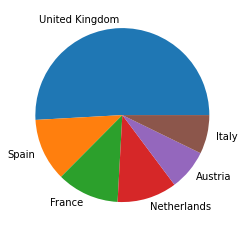

In [31]:
fig, ax = plt.subplots()
ax.pie(hotels['country'].value_counts(),labels=hotels['country'].value_counts().index);

# в датасете представлены отели из 6 стран

**Город**

In [32]:
#функция определения города из адреса отеля
def short_address(address,country):
    words=address.replace(' '+country,'').split() #удаляем из адреса страну, из оставшейся строки создаем список
    short_address=[] #пустой список
    for word in words:
        if len({'0','1','2','3','4','5','6','7','8','9'}.intersection(set(word)))==0:
            short_address.append(word)  #если в слове не содержится цифра, кладем его в будущий "короткий адрес" (таким образом исключаем из адреса номера домов и почтовые индексы)
    town=short_address[-1] #город - это последний элемент в получившемся списке
    return town

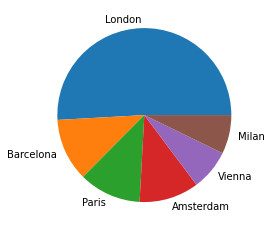

In [33]:
#создаем новый признак города, применив к признаку адреса функцию 
hotels['town']=hotels.apply(lambda x: short_address(x['hotel_address'], x['country']),axis=1)

#проверяем получившийся список городов, построив график
fig, ax = plt.subplots()
ax.pie(hotels['town'].value_counts(),labels=hotels['town'].value_counts().index);

#в датасете представлены отели из 6 городов

**Индекс**

Выделим из адреса индекс месторасположения отеля. Подстрока индекс в строке hotel_address для разных стран(городов) может находиться разных местах:
- для Лондона: округ/улица/дом - город - индекс - страна
- для Амстердама: округ/улица/дом -  - индекс - "AG" - город - страна
- для других городов: округ/улица/дом - индекс - город - страна. <br>
Будем учитывать эту особенность при поиске индекса в строке адреса.

In [34]:
#функция определения индекса
def postal_code(address, town, country):
    words=address.replace(' '+country,'').replace(' '+town,'').split() #удаляем из адреса страну и город, из оставшейся строки создаем список
    if town=='London':
        postal_code=' '.join(words[-2:])
    elif town=='Amsterdam':
        postal_code=words[-2]
    else:
        postal_code=words[-1]
    return postal_code

#создаем признак города
hotels['postal_code']=hotels.apply(lambda x: postal_code(x['hotel_address'],x['town'],x['country']),axis=1)

In [35]:
#сравним исходный признак адреса с получившимися признаками страны, города и индекса отеля. 
#убедимся, что признаки спроектированы верно
hotels[['hotel_address','country','town','postal_code']].head(3)

,hotel_address,country,town,postal_code
0,Via Senigallia 6 20161 Milan Italy,Italy,Milan,20161
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,Netherlands,Amsterdam,1043
2,Mallorca 251 Eixample 08008 Barcelona Spain,Spain,Barcelona,08008


Удаляем исходный признак адреса

In [36]:
hotels=hotels.drop('hotel_address',axis=1)

#### Преобразование даты написания отзыва

In [37]:
#извлекаем год написания отзыва из даты в отдельный признак
hotels['review_year']=pd.to_datetime(hotels['review_date']).dt.year

#удаляем исходный признак даты отзыва
hotels=hotels.drop('review_date',axis=1)

In [38]:
#извлекаем числовую часть из признака из days_since_review и преобразуем в числовой формат
def days(days_since_review):
    days=days_since_review.split()
    return int(days[0])
hotels['days_since_review']=hotels['days_since_review'].apply(days)

#### Преобразование текста отзыва

Обработаем признаки negative_review, positive_review на предмет тональности текста с помощью библиотеки SentimentIntensityAnalyzer.
Метод polarity_scores возвращает значения показателей neg,neu,pos,compound. Будем использовать показатель compound, принимающий значение от -1 (максимально негативная тональность текста) до 1 (максимально позитивная тональность). Создадим новые признаки со значениями compound

In [39]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
#создаем новые признаки
hotels['negative_review_compound']=hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
hotels['positive_review_compound']=hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

#выводим получившиеся значения для проверки
hotels[['negative_review_compound','positive_review_compound']].head()

,negative_review_compound,positive_review_compound
0,-0.0554,0.9615
1,-0.2960,0.3400
2,0.0000,0.6908
3,-0.7096,0.9153
4,-0.7096,0.7717


Возвращаемся к пустым положительным и отрицательным отзывам, которые были заполнены как "No positive" и "No Negative" - проверим, какая тональность была определена для них

In [42]:
hotels[hotels['review_total_positive_word_counts']==0][['positive_review','positive_review_compound']].value_counts()

positive_review  positive_review_compound
No Positive      0.34                        35924
dtype: int64

In [43]:
hotels[hotels['review_total_negative_word_counts']==0][['negative_review','negative_review_compound']].value_counts()

negative_review  negative_review_compound
No Negative      -0.7096                     127816
dtype: int64

Эти отзывы были интерпретированы библиотекой SentimentIntensityAnalyzer как "скорее позитные" (0.34) и "скорее негативные" (-0.7). 
Заменим их на "нейтральное значение", так как это пустые отзывы

In [44]:
hotels.loc[(hotels['review_total_positive_word_counts'] == 0), 'positive_review_compound'] = 0
hotels.loc[(hotels['review_total_negative_word_counts'] == 0), 'negative_review_compound'] = 0

In [45]:
#удалим исходные признаки текста отзывов
hotels=hotels.drop(['negative_review','positive_review'],axis=1)

### Работа с пропущенными значениями

In [46]:
#Выводим столбцы с пропусками
df_null_percent=hotels.isnull().mean()*100
df_null_percent[df_null_percent>0].sort_values(ascending=False)


lat              0.634032
lng              0.634032
nights_stayed    0.037250
dtype: float64

Пропуски имеются в столбцах широты, долготы и спроектированного признака количества ночей

#### Заполнение координат отеля

Для нахождения недостающих координат отеля воспользуемся библиотекой geocode. Это библиотека Python для запроса GPS-координат, названия региона и названия муниципалитета из почтовых индексов. 

In [47]:
!pip install pgeocode
import pgeocode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
#создаем словарь с названиями стран из нашего датасета и соответствующими им кодами стран в библиотеке pgeocode
coutry_codes={'United Kingdom': 'GB',
              'Spain': 'ES',
              'France': 'FR',
              'Netherlands':'NL',
              'Austria': 'AT',
              'Italy': 'IT'}

#функции нахождения координат по стране и индексу муниципалитета
def find_lat(latitude,country,code): #широта
    if pd.isnull(latitude):
        nomi = pgeocode.Nominatim(coutry_codes[country])
        latitude=nomi.query_postal_code(code)['latitude']
    return latitude

def find_long(longitude,country,code):  #долгота
    if pd.isnull(longitude):
        nomi = pgeocode.Nominatim(coutry_codes[country])
        longitude=nomi.query_postal_code(code)['longitude']
    return longitude

In [49]:
#заполняем пропуски в координатах отелей, применив функции
hotels['lat']=hotels.apply(lambda x:find_lat(x['lat'],x['country'],x['postal_code']),axis=1 )
hotels['lng']=hotels.apply(lambda x:find_long(x['lng'],x['country'],x['postal_code']),axis=1 )

#### Количество ночей

Пропуски в столбце с количеством ночей заполним модальными значениями для данного отеля.

In [50]:
#создаем сводную таблицу с названиями отелей и модальным значением количества ночей, на которое останавливаются в них гости
mode_nights=hotels[['hotel_name','nights_stayed']].groupby('hotel_name').agg(lambda x: pd.Series.mode(x)[0])
mode_nights.head()

,nights_stayed
hotel_name,
11 Cadogan Gardens,1
1K Hotel,1
25hours Hotel beim MuseumsQuartier,2
41,1
45 Park Lane Dorchester Collection,1


In [51]:
def fillna_nights(nights,hotel):
    if pd.isnull(nights):
        nights=mode_nights.loc[hotel]['nights_stayed']
    return nights
hotels['nights_stayed']=hotels.apply(lambda x: fillna_nights(x['nights_stayed'], x['hotel_name']),axis=1)

In [52]:
hotels['nights_stayed'] = hotels['nights_stayed'].astype('int')

In [53]:
#проверяем повторно пропуски
df_null_percent=hotels.isnull().mean()*100
df_null_percent[df_null_percent>0].sort_values(ascending=False)

Series([], dtype: float64)

### Проектирование признаков - этап 2
#### Расстояние от центра города

Имея данные по координатам каждого отеля, спроектируем новый признак -  расстояние до отеля от центра города. Расстояние можно определить с помощью  библиотеки geopy по координатам двух точек.
Создадим датафрейм с координатами центра городов, которые взяты из Яндекс.Карт

In [54]:
#датафрейм с координатами центра городов
center_coord=pd.DataFrame(
data = [
['London', (51.507351, -0.127696)],
['Barcelona',(41.392696, 2.144449)],
['Paris', (48.856663, 2.351556)],
['Amsterdam', (52.373057, 4.892557)],
['Vienna', (48.206487, 16.363460)],
['Milan', (45.464183, 9.189595)]],
columns = ['name', 'coordinates']
)
center_coord

,name,coordinates
0,London,"(51.507351, -0.127696)"
1,Barcelona,"(41.392696, 2.144449)"
2,Paris,"(48.856663, 2.351556)"
3,Amsterdam,"(52.373057, 4.892557)"
4,Vienna,"(48.206487, 16.36346)"
5,Milan,"(45.464183, 9.189595)"


In [55]:
#загружаем бибилотеку и модули
!pip install geopy
import geopy.distance
from geopy.distance import geodesic as GD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
#функция нахождения расстояния от центра
def distance(lat,lng,town,center_coord):
    center=center_coord[center_coord['name']==town]['coordinates']
    hotel=(lat,lng)
    return GD(center,hotel).km
#создаем признак расстояния от центра
hotels['distance']=hotels.apply(lambda x: distance(x['lat'],x['lng'],x['town'],center_coord),axis=1)

In [57]:
hotels[['distance']].describe()

,distance
count,515431.000000
mean,3.243504
std,2.529761
min,0.072935
25%,1.513387
50%,2.595905
75%,4.095056
max,17.197663


In [121]:
hotels=hotels.drop('postal_code',axis=1)

### Кодирование признаков

In [123]:
#Датасет с кодированными признаками в дальнейшем будет называться hotels_encoded
hotels_encoded=hotels.copy()

#### 1. Теги

In [124]:
hotels_encoded['tags'].head()

0    [' Leisure trip ', ' Couple ', ' Double Room '...
1    [' Leisure trip ', ' Group ', ' Triple Room ',...
2    [' Business trip ', ' Solo traveler ', ' Twin ...
3    [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4    [' Business trip ', ' Solo traveler ', ' Class...
Name: tags, dtype: object

Теги в каждом отзыве содержатся в виде списка тегов (при этом тип данных - object). Для анализа и кодирования этого признака необходимо "разрушить" ячейки таким образом, чтобы в одной ячейке был один тег. Для этого создадим новый датасет tags_exploded, в котором будут все теги из исходного датасета. После этой операции количество строк существенно увеличится, поэтому вынесем теги в отдельную таблицу tags_exploded

In [125]:
hotels_encoded['tag'] = hotels_encoded['tags'].apply(literal_eval) #преобразование строки в список
tags_exploded=hotels_encoded[['tag']].explode('tag')
tags_exploded.head(10)

,tag
0,Leisure trip
0,Couple
0,Double Room
0,Stayed 2 nights
1,Leisure trip
1,Group
1,Triple Room
1,Stayed 1 night
2,Business trip
2,Solo traveler


Таким образом, теги вынесены в отдельную таблицу, дублирующиеся индексы означают принадлежность тегов к одному и тому же отзыву

Для начала определим 30 наиболее часто встречающихся тегов, заменив тегом 'Other' те, в которых содержится количество ночей и количество комнат, так как эта информация была вынесена в отдельные признаки nights_stayed и rooms

In [126]:
rooms_nights_info=['night','Room','room','Double','Twin','2 room','Triple', 'Queen','King','3 room','Standard','Studio']   #эти слова в тегах указывают на количество мест(комнат) или количтесво ночей
def extract_unique_tags(cell):
  for element in rooms_nights_info:
    if element in cell:
      cell='Other'
  return cell
tags_exploded['tag']=tags_exploded['tag'].apply(extract_unique_tags)

In [127]:
#30 часто встречающиxся теги
popular_tags=tags_exploded['tag'].value_counts(sort=True,ascending=False).head(30)
popular_tags

Other                                           1016288
 Leisure trip                                    417538
 Submitted from a mobile device                  307470
 Couple                                          252128
 Solo traveler                                   108476
 Business trip                                    82884
 Group                                            65361
 Family with young children                       60989
 Family with older children                       26334
 Junior Suite                                      4555
 Travelers with friends                            2143
 Suite                                             1897
 With a pet                                        1405
 Luxury Suite                                       303
 Superior                                           270
 Family Suite                                       219
 Junior Suite 2 Adults                              195
 Executive Suite                                

Оставим в признаке  tag эти 30 тегов, а остальные добавим к категории Other и посмотрим их процентное распределение графически

In [128]:
tags_exploded['tag']=tags_exploded['tag'].apply(lambda x: x if x in list(popular_tags.index) else 'Other')

In [129]:
tags_exploded['tag'].value_counts()

Other                                           1021338
 Leisure trip                                    417538
 Submitted from a mobile device                  307470
 Couple                                          252128
 Solo traveler                                   108476
 Business trip                                    82884
 Group                                            65361
 Family with young children                       60989
 Family with older children                       26334
 Junior Suite                                      4555
 Travelers with friends                            2143
 Suite                                             1897
 With a pet                                        1405
 Luxury Suite                                       303
 Superior                                           270
 Family Suite                                       219
 Junior Suite 2 Adults                              195
 Executive Suite                                

In [130]:
df= tags_exploded['tag'].value_counts(sort=True,ascending=False).to_frame().reset_index()   #создан датафрейм для построения графика Парето
df

,index,tag
0,Other,1021338
1,Leisure trip,417538
2,Submitted from a mobile device,307470
3,Couple,252128
4,Solo traveler,108476
5,Business trip,82884
6,Group,65361
7,Family with young children,60989
8,Family with older children,26334
9,Junior Suite,4555


In [131]:
df=df.rename(index={0:31}).sort_index().reset_index(drop=True)  #переместили other в конец датафрейма для построения графика

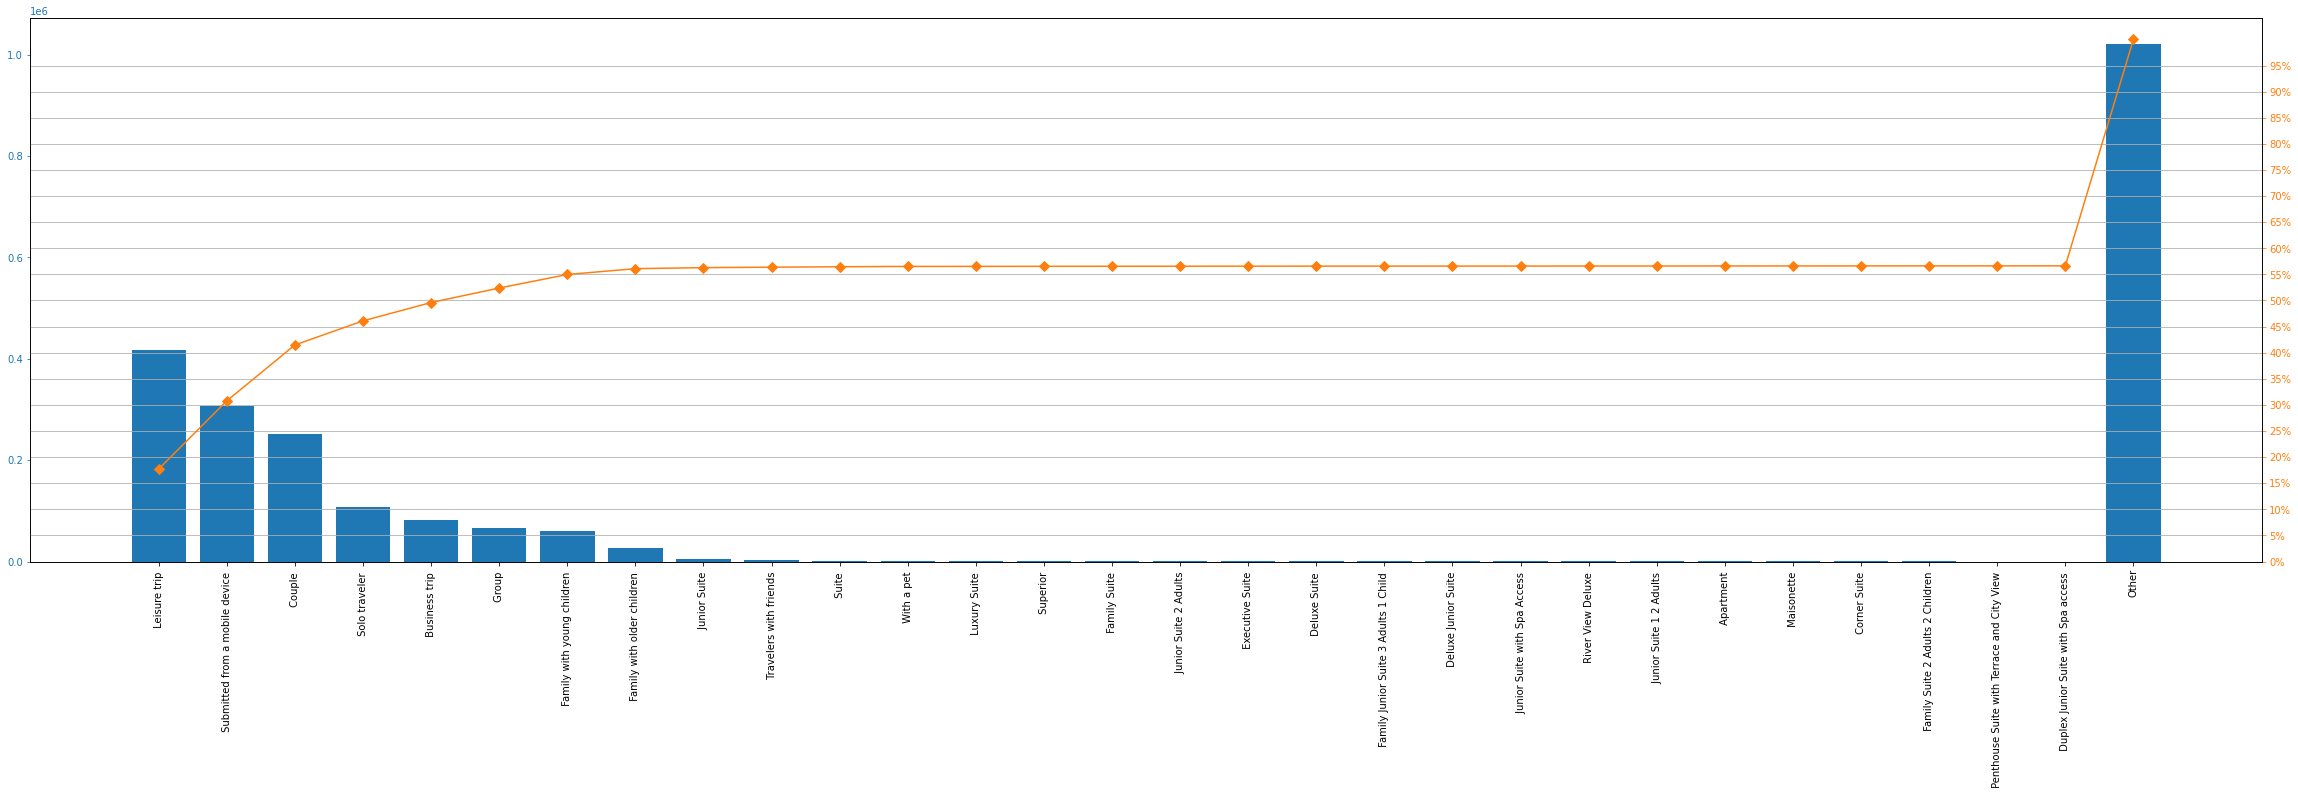

In [132]:
import numpy as np
from matplotlib.ticker import PercentFormatter

df["cumpercentage"] = df["tag"].cumsum()/df["tag"].sum()*100

fig, ax = plt.subplots(figsize=(40,10))
ax.bar(df['index'], df["tag"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(visible=True,which='both')
plt.yticks(np.arange(0, 100, step=5))
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.xaxis.set_tick_params(rotation=90)
plt.show()

Из графика Парето видно, что 55% тегов составляют 7 наиболее популярных тегов. 
Оставляем только эти 7 тегов, остальные перемещаем в категорию Other

In [133]:
popular_tags=tags_exploded['tag'].value_counts(sort=True,ascending=False).head(8)  #7 популярных тегов + тег Other
popular_tags

Other                               1021338
 Leisure trip                        417538
 Submitted from a mobile device      307470
 Couple                              252128
 Solo traveler                       108476
 Business trip                        82884
 Group                                65361
 Family with young children           60989
Name: tag, dtype: int64

In [134]:
tags_exploded['tag']=tags_exploded['tag'].apply(lambda x: x if x in list(popular_tags.index) else 'Other')

In [135]:
#выполним кодирование тегов методом OneHot Encoding
encoder=ce.OneHotEncoder(cols=['tag'])
type_bin=encoder.fit_transform(tags_exploded['tag'])
tags_exploded=pd.concat([tags_exploded,type_bin],axis=1)
tags_exploded.head(20)

,tag,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Leisure trip,1,0,0,0,0,0,0,0
0,Couple,0,1,0,0,0,0,0,0
0,Other,0,0,1,0,0,0,0,0
0,Other,0,0,1,0,0,0,0,0
1,Leisure trip,1,0,0,0,0,0,0,0
1,Group,0,0,0,1,0,0,0,0
1,Other,0,0,1,0,0,0,0,0
1,Other,0,0,1,0,0,0,0,0
2,Business trip,0,0,0,0,1,0,0,0
2,Solo traveler,0,0,0,0,0,1,0,0


In [136]:
#теги Other закодировались как tag_3. Поскольку в эту категорию входят теги с информацией о количестве ночей и комнат, а также другие непопулярные теги, удалим этот признак из датасета
tags_exploded=tags_exploded.drop('tag_3',axis=1)

In [137]:
#сгруппируем таблицу с кодами тегов по индексам, чтобы заново "собрать" разрушенную таблицу тегов и привести количество строк в соответствие с исходной таблицей. При группировке коды тегов агрегируются методом max.

tags_collapsed=tags_exploded.drop(['tag'],axis=1).groupby(tags_exploded.index).max()
  #возвращаем исходные индексы
tags_collapsed.head(5)

,tag_1,tag_2,tag_4,tag_5,tag_6,tag_7,tag_8
0,1,1,0,0,0,0,0
1,1,0,1,0,0,0,0
2,0,0,0,1,1,1,0
3,1,1,0,0,0,0,0
4,0,0,0,1,1,1,0


In [138]:
hotels_encoded.shape,tags_collapsed.shape

((515431, 23), (515431, 7))

Теперь количество строк кодированного датасета тегов и исходного датасета совпадают, и можно их объединить

In [139]:
hotels_encoded=pd.concat([hotels_encoded,tags_collapsed], axis=1)
hotels_encoded=hotels_encoded.drop(['tags','tag'],axis=1)

In [140]:
hotels_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   review_total_negative_word_counts           515431 non-null  int64  
 5   total_number_of_reviews                     515431 non-null  int64  
 6   review_total_positive_word_counts           515431 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 8   days_since_review                           515431 non-null  int64  
 9   lat                                         515431 non-null  float64
 

#### 2. Национальность автора отзыва

Для начала выведем 30 наиболее часто встречающихся национальностей рецензентов, остальные заменим на Other. По аналогии с тегами построим график Парето

In [141]:
popular_nat=hotels_encoded['reviewer_nationality'].value_counts(sort=True,ascending=False).head(30)

In [142]:
hotels_encoded['reviewer_nationality']=hotels_encoded['reviewer_nationality'].apply(lambda x: x if x in list(popular_nat.index) else 'Other')

In [143]:
df= hotels_encoded['reviewer_nationality'].value_counts(sort=True,ascending=False).to_frame().reset_index()
df

,index,reviewer_nationality
0,United Kingdom,245165
1,Other,61592
2,United States of America,35390
3,Australia,21663
4,Ireland,14820
5,United Arab Emirates,10230
6,Saudi Arabia,8945
7,Netherlands,8762
8,Switzerland,8672
9,Germany,7936


In [144]:
df=df.rename(index={1:31}).sort_index().reset_index(drop=True)  #переместили other в конец датафрейма для построения графика

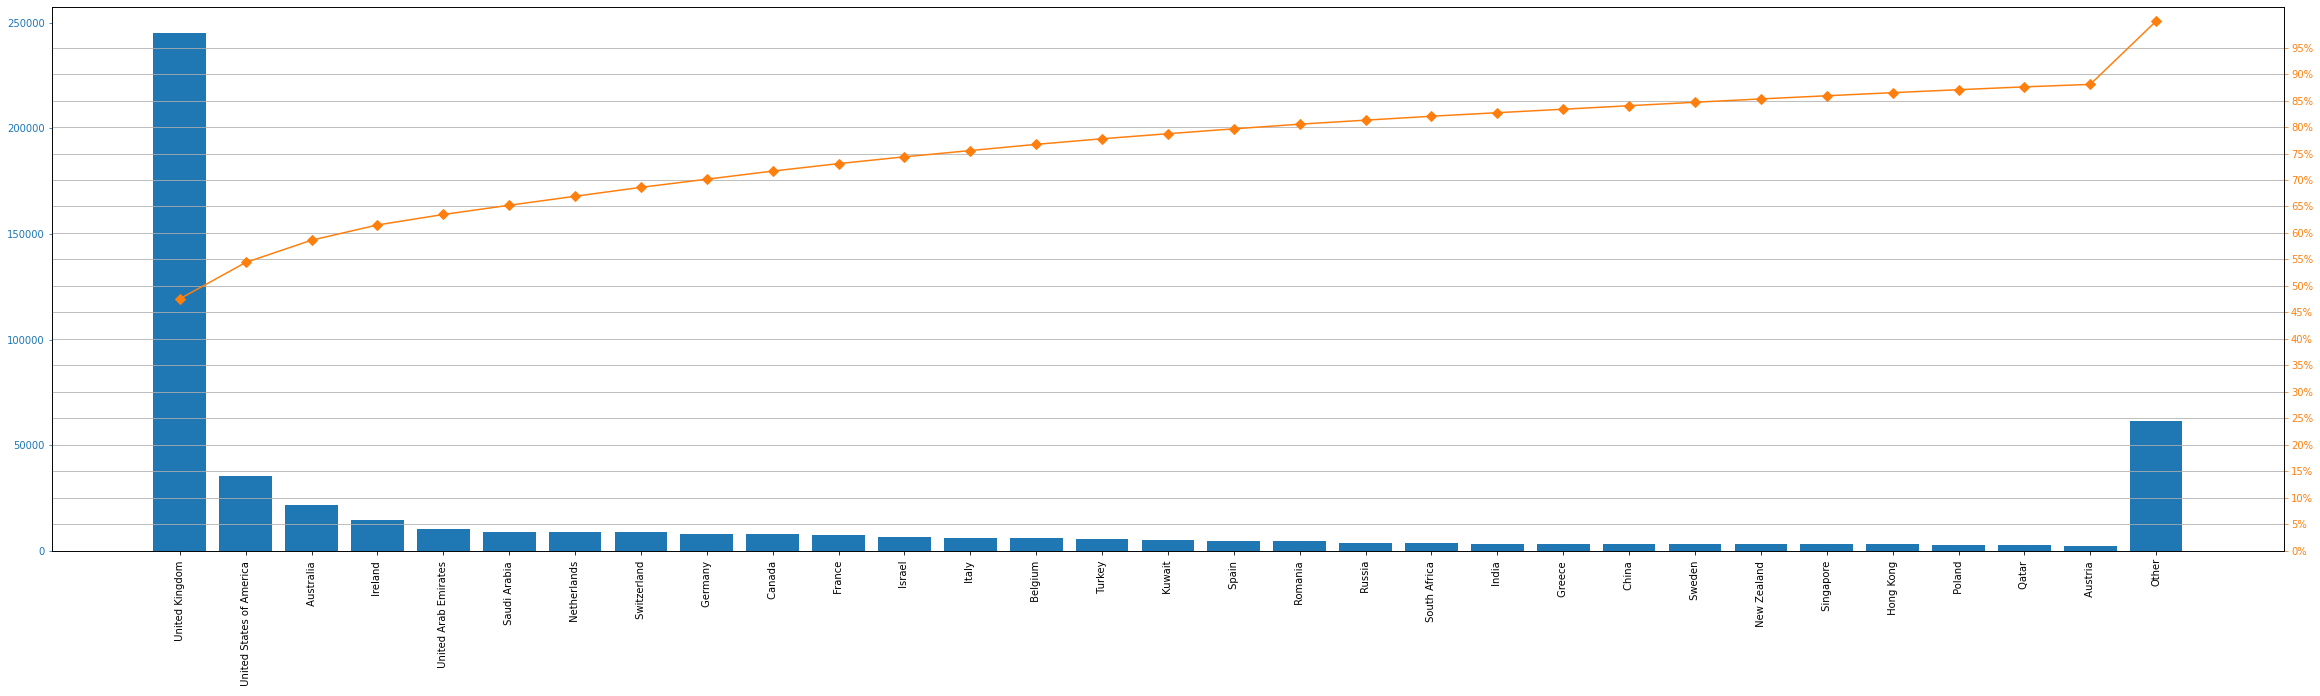

In [145]:
import numpy as np
from matplotlib.ticker import PercentFormatter

df["cumpercentage"] = df["reviewer_nationality"].cumsum()/df["reviewer_nationality"].sum()*100

fig, ax = plt.subplots(figsize=(40,10))
ax.bar(df['index'], df["reviewer_nationality"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(visible=True,which='both')
plt.yticks(np.arange(0, 100, step=5))
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.xaxis.set_tick_params(rotation=90)
plt.show()

Из графика Парето видно, что 70% тегов составляют 9 наиболее популярных национальностей. Оставляем только эти 9 национальностей, остальные добавялем в категорию Other

In [146]:
popular_nat=hotels_encoded['reviewer_nationality'].value_counts(sort=True,ascending=False).head(10)
hotels_encoded['reviewer_nationality']=hotels_encoded['reviewer_nationality'].apply(lambda x: x if x in list(popular_nat.index) else 'Other')

In [147]:
# кодирование признака методом OneHot Encoding
encoder=ce.OneHotEncoder(cols=['reviewer_nationality'])
type_bin=encoder.fit_transform(hotels_encoded['reviewer_nationality'])
hotels_encoded=pd.concat([hotels_encoded,type_bin],axis=1)
hotels_encoded.head(5)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,sample,nights_stayed,rooms,country,town,review_year,negative_review_compound,positive_review_compound,distance,tag_1,tag_2,tag_4,tag_5,tag_6,tag_7,tag_8,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,reviewer_nationality_8,reviewer_nationality_9,reviewer_nationality_10
0,904,8.1,Hotel Da Vinci,United Kingdom,52,16670,62,1,13,45.533137,9.171102,0.0,test,2,2,Italy,Milan,2017,-0.0554,0.9615,7.798791,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,612,8.6,Urban Lodge Hotel,Other,10,5018,0,7,234,52.385649,4.834443,0.0,test,1,3,Netherlands,Amsterdam,2016,-0.2960,0.0000,4.198078,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Other,3,351,5,15,616,41.393192,2.161520,0.0,test,1,2,Spain,Barcelona,2015,0.0000,0.6908,1.428769,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0
3,241,9.1,Hotel Principe Di Savoia,United States of America,0,1543,27,9,656,45.479888,9.196298,0.0,test,1,3,Italy,Milan,2015,0.0000,0.9153,1.822475,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,834,9.1,Hotel Esther a,United Kingdom,0,4687,7,2,444,52.370545,4.888644,0.0,test,2,2,Netherlands,Amsterdam,2016,0.0000,0.7717,0.386237,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0


In [148]:
#национальности Other закодировались как 	reviewer_nationality_2, оставим этот признак, а исходный признак reviewer_nationality удалим
hotels_encoded=hotels_encoded.drop('reviewer_nationality',axis=1)

#### 3. Адрес

In [149]:
# кодирование признака страны
hotels_encoded['country'].nunique()

encoder=ce.OneHotEncoder(cols=['country'])
type_bin=encoder.fit_transform(hotels_encoded['country'])
hotels_encoded=pd.concat([hotels_encoded.drop('country',axis=1),type_bin],axis=1)

In [150]:
hotels_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   total_number_of_reviews                     515431 non-null  int64  
 5   review_total_positive_word_counts           515431 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 7   days_since_review                           515431 non-null  int64  
 8   lat                                         515431 non-null  float64
 9   lng                                         515431 non-null  float64
 

### Нормализация признаков

Нормализуем все числовые признаки по следующей схеме:
1. Выделим списки числовых признаков num_cols (кроме целевой переменной reviewer_score) и строковых object_cols + целевой переменной reviewer_score
2. Нормализуем датасет, состоящий только из числовых признаков, методом RobustScaler
3. Присоединим к нормализованному датасету hotels_scaled столбцы со строковыми данными датасета hotels

In [178]:
num_cols = [s for s in hotels_encoded.columns if hotels_encoded[s].dtypes != 'object']
object_cols = [s for s in hotels_encoded.columns if hotels_encoded[s].dtypes == 'object']

In [179]:
num_cols.remove('reviewer_score')
object_cols.append('reviewer_score')

In [180]:
#нормализация
from sklearn import preprocessing
r_scaler=preprocessing.MinMaxScaler()
hotels_scaled=r_scaler.fit_transform(hotels_encoded[num_cols])
hotels_scaled=pd.DataFrame(hotels_scaled,columns=num_cols,index=list(hotels_encoded.index)) #сохраняем исходные индексы строк

#объединение строковых признаков с нормализованными числовыми признаками
hotels_normalized=pd.concat([hotels_scaled,hotels_encoded[object_cols]], axis=1)

### ОТБОР ПРИЗНАКОВ

Необходимо провести анализ мультиколлинеарности, чтобы выбрать уникальные признаки для модели.

In [181]:
#сразу удаляем признак города, так как он будет коррелировать со страной (в датасете представлено по одному городу в каждой стране)
hotels_normalized=hotels_normalized.drop(['town'],axis=1)

Преобразованный датасет с удаленными неинформативными признаками в дальнейшем будет называться hotels_selected

In [182]:
hotels_selected=hotels_normalized.copy()

Построим матрицу корреляции по методу Кендалла. Выбран данный метод, так как в таблице имеются категориальные признаки, а также непрерывные признаки, не очищенные от выбросов. 

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


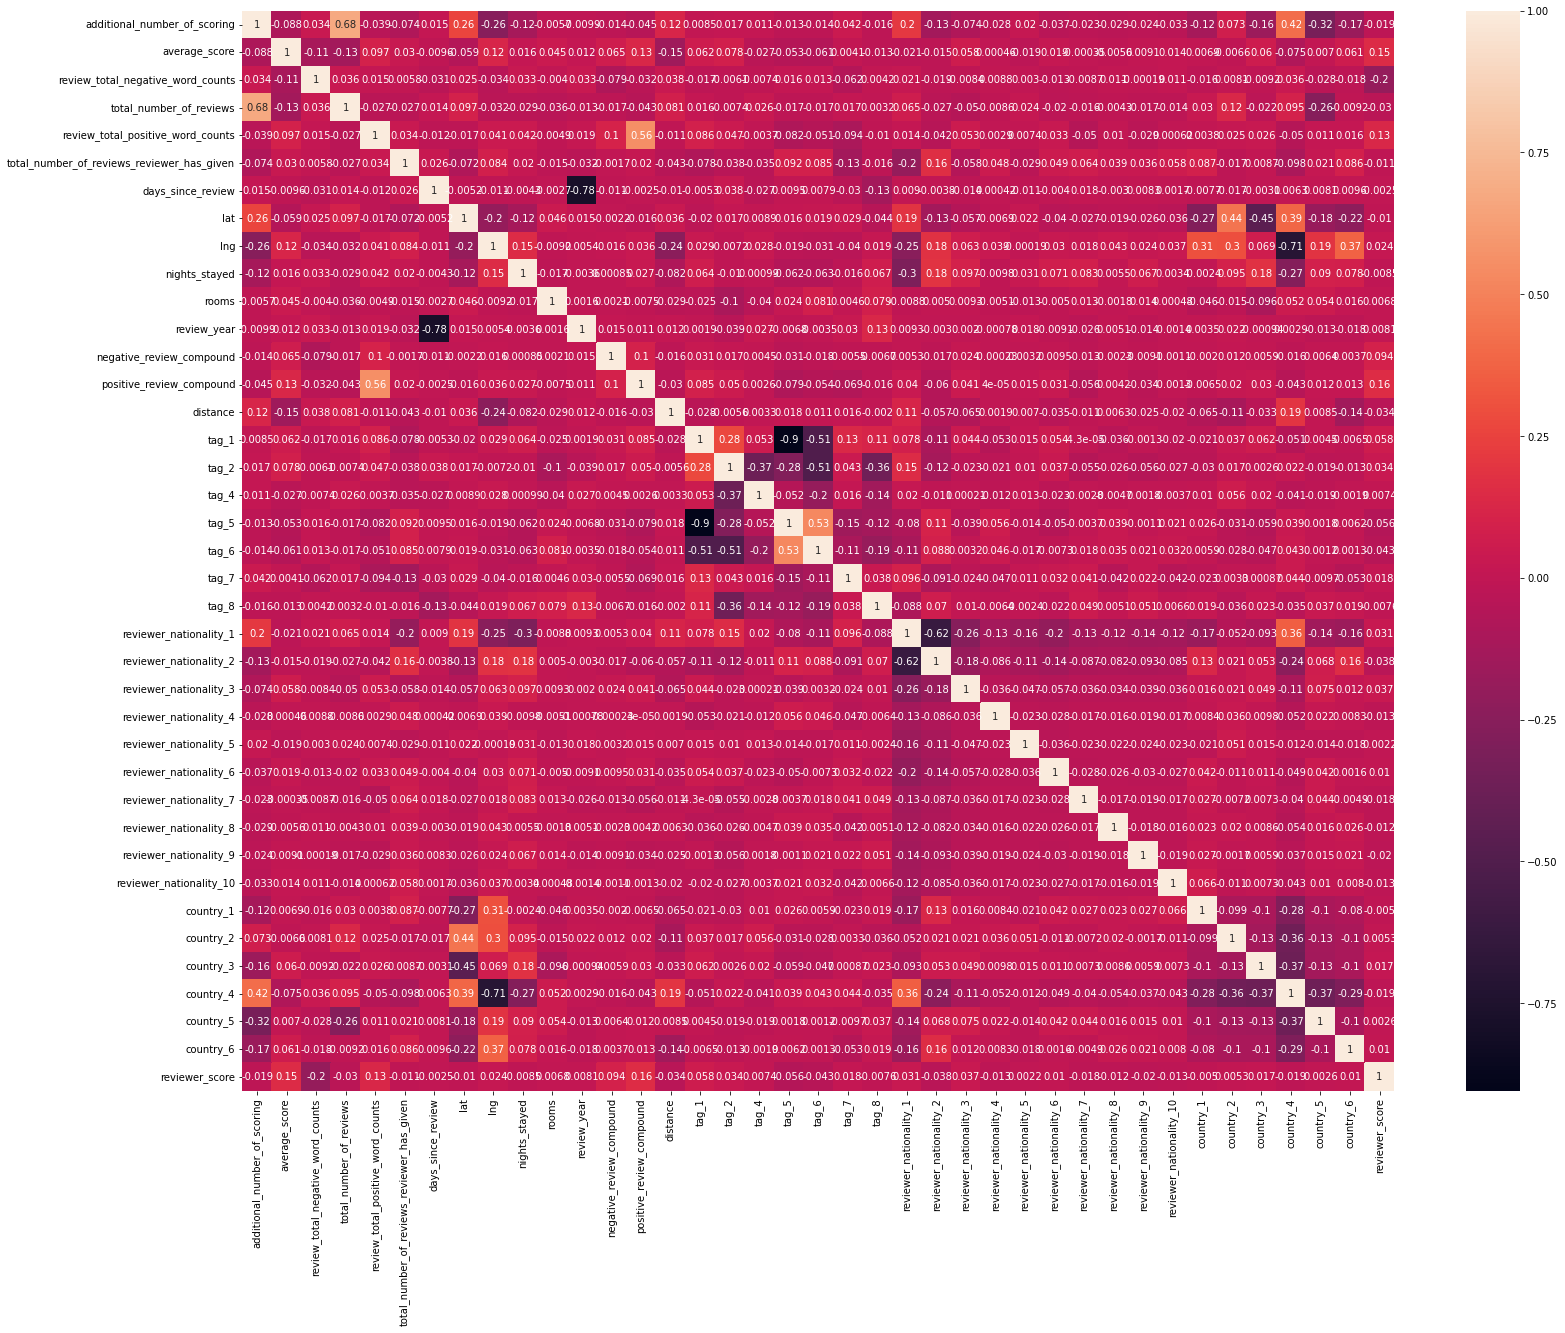

In [183]:
fig=plt.figure(figsize=(20,15))
axes=fig.add_axes([0,0,1,1])
sns.heatmap(hotels_selected.corr(method='kendall'),ax=axes, annot=True);

Наблюдается мультиколлинеарность по парам признаков:
- days_since_review, review_year
- tag_1/tag_5
- lng, country_4 <br>
Решение о том, какие признаки из этих пар будут удалены, будет принято после оценки значимости признаков

### Разделение набора данных перед построением модели

In [184]:
#удаляем строковые признаки, которые не будут использоваться в дальнейшем в модели
hotels_selected.drop(['hotel_name'], axis = 1, inplace=True)
hotels_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  float64
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  float64
 3   total_number_of_reviews                     515431 non-null  float64
 4   review_total_positive_word_counts           515431 non-null  float64
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  float64
 6   days_since_review                           515431 non-null  float64
 7   lat                                         515431 non-null  float64
 8   lng                                         515431 non-null  float64
 9   nights_stayed                               515431 non-null  float64
 

In [185]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  

# выделим тренировочную и тестовую части 
train_data = hotels_selected[hotels_selected['sample'] == 'train'].drop(['sample'], axis=1)
test_data = hotels_selected[hotels_selected['sample'] == 'test'].drop(['sample'], axis=1)

# Х - данные с информацией об отелях (исключаем признак названия отеля и местоположения отеля, у - целевая переменная (рейтинги отелей) 
y = train_data.reviewer_score.values    # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)


### Оценка значимости признаков 

Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

In [186]:
hotels_selected.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'nights_stayed', 'rooms', 'review_year',
       'negative_review_compound', 'positive_review_compound', 'distance',
       'tag_1', 'tag_2', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8',
       'reviewer_nationality_1', 'reviewer_nationality_2',
       'reviewer_nationality_3', 'reviewer_nationality_4',
       'reviewer_nationality_5', 'reviewer_nationality_6',
       'reviewer_nationality_7', 'reviewer_nationality_8',
       'reviewer_nationality_9', 'reviewer_nationality_10', 'country_1',
       'country_2', 'country_3', 'country_4', 'country_5', 'country_6',
       'sample', 'reviewer_score'],
      dtype='object')

In [188]:
# категориальные признаки
cat_cols = ['tag_1', 'tag_2', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8',
       'reviewer_nationality_1', 'reviewer_nationality_2',
       'reviewer_nationality_3', 'reviewer_nationality_4',
       'reviewer_nationality_5', 'reviewer_nationality_6',
       'reviewer_nationality_7', 'reviewer_nationality_8',
       'reviewer_nationality_9', 'reviewer_nationality_10', 'country_1',
       'country_2', 'country_3', 'country_4', 'country_5', 'country_6']

 # непрерывные признаки
num_cols = ['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'nights_stayed', 'rooms', 'review_year',
       'negative_review_compound', 'positive_review_compound', 'distance']

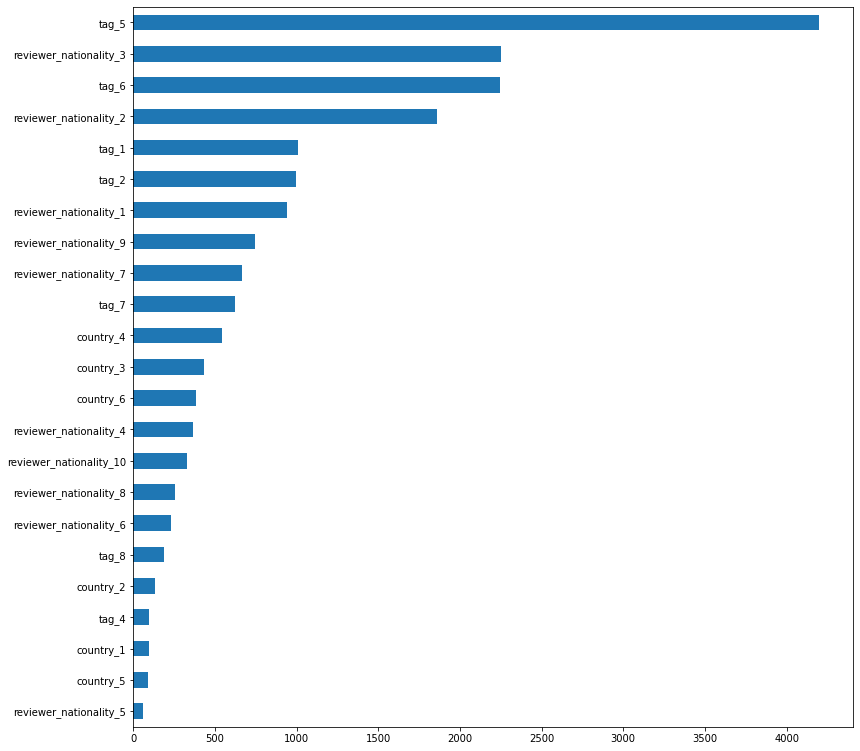

In [189]:
#график значимости категориальных признаков
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат
fig=plt.figure(figsize=(10,10))
axes=fig.add_axes([0,0,1,1])
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

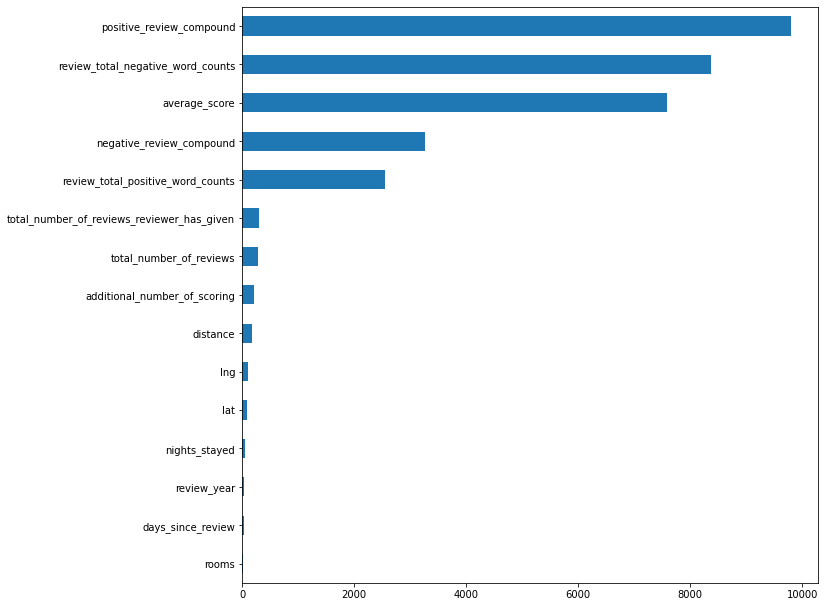

In [190]:
#график значимости непрерывных признаков
from sklearn.feature_selection import f_classif # anova
fig=plt.figure(figsize=(8,8))
axes=fig.add_axes([0,0,1,1])
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

После нескольких итераций отбора признаков, создания и обучения модели были определены признаки, удаление которых приводит к улучшению модели. Это признаки rooms, days_since_review, lat, lng

In [191]:
#список признаков для удаления
less_important=['rooms','days_since_review','lat','lng']

In [192]:
#удаляем признаки из тренировочных и тестовых данных, и данных Х
train_data=train_data.drop(less_important,axis=1)
test_data=test_data.drop(less_important,axis=1)
X=X.drop(less_important,axis=1)

### Создание и обучение модели

In [194]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [195]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 35), (386496, 35), (386496, 34), (309196, 34), (77300, 34))

In [196]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [197]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [198]:
# Обучаем модель на тренировочном наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.1s finished


In [199]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14876056571490176


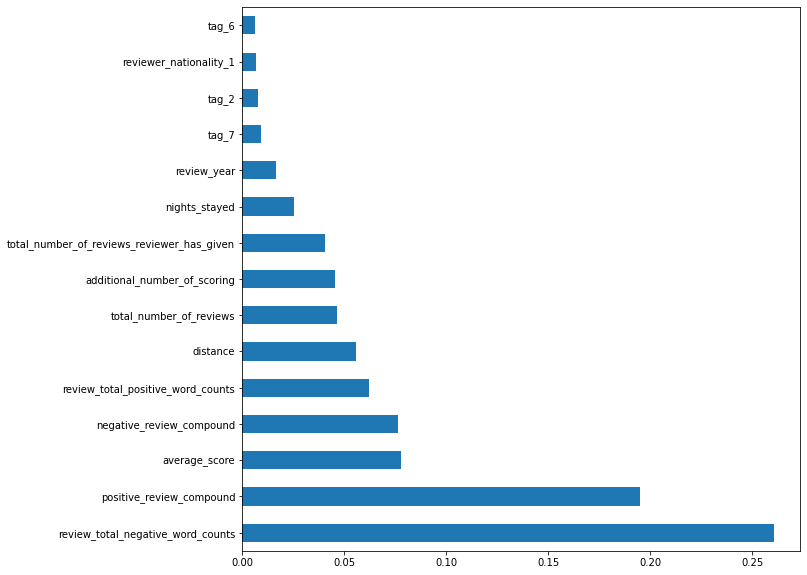

In [200]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Подготовка файла для сабмита в соревнование

In [201]:
test_data = test_data.drop(['reviewer_score'], axis=1)   #удаляем целевую переменную в тестовом датасете, которую мы ранее заполняли нулями

In [202]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.2s finished


In [203]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('/content/drive/MyDrive/Colab Notebooks/data/submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.53,488440
1,6.73,274649
2,8.20,374688
3,9.56,404352
4,9.15,451596
5,8.65,302161
6,7.50,317079
7,7.15,13963
8,8.03,159785
9,7.45,195089
